In [1]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

/usr/local/art/.venv/lib/python3.12/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.12/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [33]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils

import shap
import matplotlib.pyplot as plt

### Define directories

In [5]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [16]:
ZaireEbolavirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "ZaireEbolavirusData_chEMBL_wMACAW.csv")
ZaireEbolavirusData_chEMBL_wMACAW

,ID,compound_id,Smiles,pPotency,StrainClassifier,pPotency_category,MACAW_1,MACAW_2,MACAW_3,MACAW_4,...,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.173925,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
1,2,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.173925,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
2,3,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.619789,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
3,4,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.619789,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
4,5,CHEMBL5611967,O=C(Nc1cccc(Cl)c1)c1ccc(-c2cccc(OC3CCNCC3)c2)s1,5.730487,ZaireEbola,3-10,0.194000,0.271922,0.028860,0.008549,...,0.004466,-0.010283,0.023163,0.044987,0.174677,0.079320,0.070356,-0.031430,-0.032638,0.182068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,131,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,0.002611,-0.102177,-0.327227,0.065414,...,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
131,132,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,0.002611,-0.102177,-0.327227,0.065414,...,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
132,133,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,-0.027520,-0.131712,-0.412087,-0.021914,...,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560
133,134,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,-0.027520,-0.131712,-0.412087,-0.021914,...,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560


In [17]:
ZaireEbolavirusData_chEMBL_wMACAW.columns

Index(['ID', 'compound_id', 'Smiles', 'pPotency', 'StrainClassifier',
       'pPotency_category', 'MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4',
       'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10',
       'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15'],
      dtype='object')

### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

Find Features and Response

In [19]:
input_var = [col for col in ZaireEbolavirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(input_var)

['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [20]:
features = ZaireEbolavirusData_chEMBL_wMACAW[input_var].to_numpy()

In [21]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [22]:
response = ZaireEbolavirusData_chEMBL_wMACAW[response_var].to_numpy()

And then save the data as a EDD style file (see "Importing a Study" here):

In [23]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'ZaireEbolavirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [24]:
ZaireEbolavirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "ZaireEbolavirusData_chEMBL_wMACAW_ARTready.csv")
ZaireEbolavirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.597267
1,1,MACAW_1,-0.597267
2,2,MACAW_1,-0.597267
3,3,MACAW_1,-0.597267
4,4,MACAW_1,0.194000
...,...,...,...
2155,130,pPotency,6.283997
2156,131,pPotency,6.283997
2157,132,pPotency,5.721246
2158,133,pPotency,5.721246


Let's now define the ART parameters needed for the prediction of production

In [29]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    # Uncomment this to avoid a random seed
    'output_dir': '.',
}

And then run ART without recommendations but with cross-validations to gauge how generalizable the results are:

In [30]:
ZaireEbolavirusData_chEMBL_wMACAW_ARTready.columns

Index(['Line Name', 'Type', '0.0'], dtype='object')

ART identified 135 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_

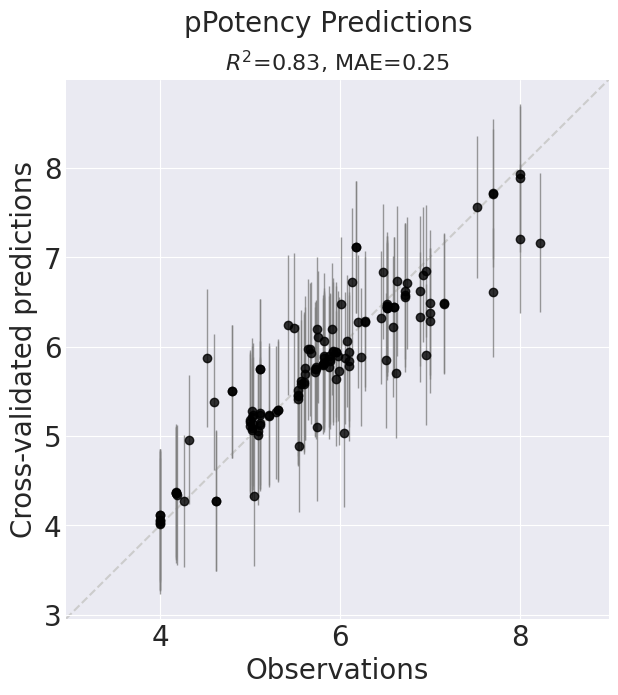

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


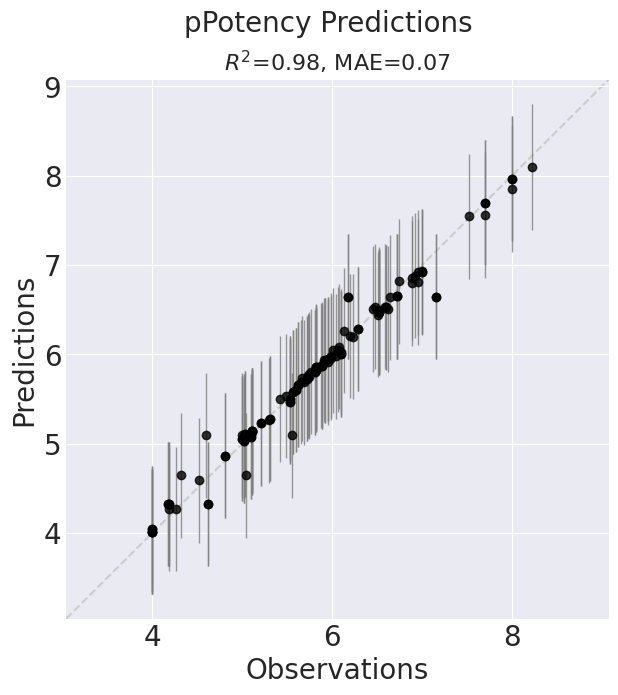

CPU times: user 3min 3s, sys: 3.1 s, total: 3min 6s
Wall time: 24min 19s


In [31]:
%%time

art = RecommendationEngine(df=ZaireEbolavirusData_chEMBL_wMACAW_ARTready, **art_params,recommend=False,cross_val=True)

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [34]:
shap.initjs()

In [35]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [36]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [38]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [39]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

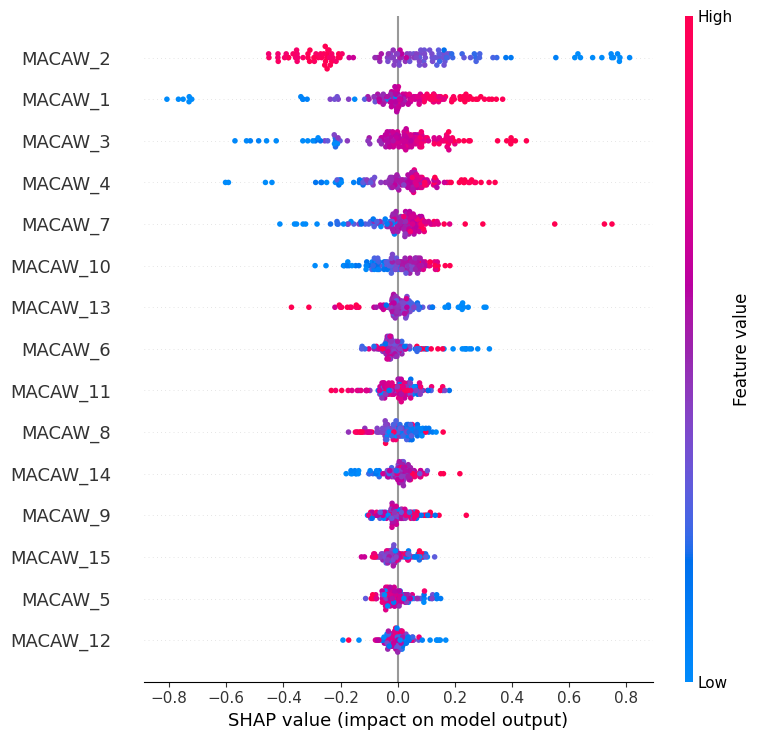

In [40]:
shap.summary_plot(shap_values_e)

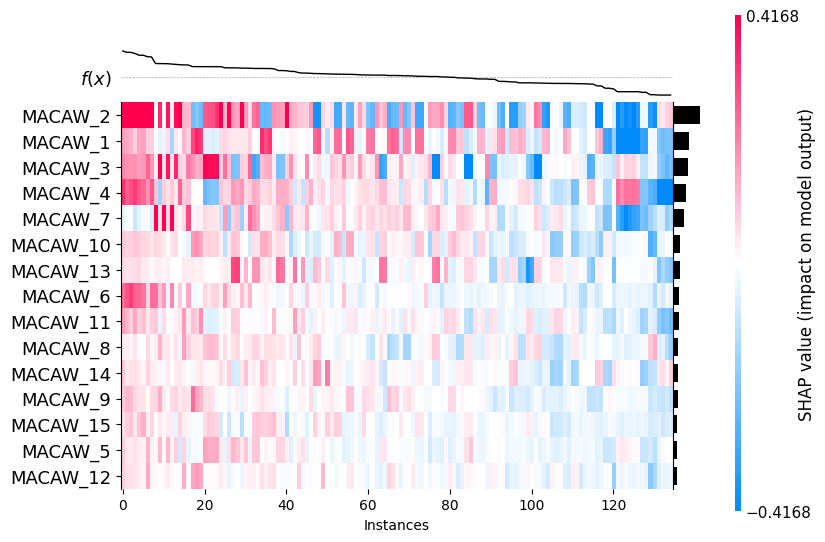

<Axes: xlabel='Instances'>

In [41]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [5]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

,Smiles,VirusClassifier,pPotency
0,C#CN(CCCC1(C)N=N1)C(=O)[C@]12CCC(C)(C)C[C@H]1C...,Ebola,6.330404
1,C#C[C@@]1(c2ccc3c(N)ncnn23)O[C@H](COP(=O)(N[C@...,Ebola,5.408935
2,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,Ebola,4.889410
3,C1=C2CCCN(Cc3ccccc3)[C@H]2[C@@H]2C[C@H]1[C@H]1...,Ebola,4.818156
4,C1=C2CCCN[C@H]2[C@@H]2C[C@H]1[C@H]1CCCCN1C2,Ebola,4.906578
...,...,...,...
451,[2H]C([2H])(c1cc(Cl)ccc1N)N1CCN(C(=O)CNC(=O)C2...,Ebola,6.907342
452,[2H]C([2H])(c1cc(Cl)ccc1N)N1CCN(C(=O)CNC(=O)CC...,Ebola,6.191151
453,[2H]C([2H])(c1cc(Cl)ccc1NCc1ccc(S(C)(=O)=O)cc1...,Ebola,7.320177
454,c1cc(NCCCCN2CCOCC2)c2nccc(NCCCCN3CCOCC3)c2n1,Ebola,5.327058


### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES